# Random attacks and network robustness
For this assignment we will be taking a look at how robust networks are to failure, similar to what you saw in the Barabasi readings. From the reading we learned that random node removal can fragment the network very quickly in lattices. The point where the largest component vanishes is the critical point and it occurs sharply in those types of graphs. We can actually write a short program to do this ourselves and produce a similar bifurcation diagram as in the reading.

In [1]:
# First lets load the libraries we need
import networkx as nx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
# Now lets define a function that will return our order parameter, which will
# be the relative size of the giant component to its original size.
# This function will take a networkx graph as an argument
# as well as the fraction of nodes we want to remove
def random_removal(graph, remove_frac):
    
    # First, lets copy the graph so we don't change the original
    graph = graph.copy()
    
    # We need to calculate the current size of the largest component
    initial_largest = len(max(nx.connected_component_subgraphs(graph), key=len))
    
    # Once that is done, we can randomly remove a fraction of the nodes from the network
    # We do this by using numpy's random choice function and having it pick random
    # nodes without replacement from the network. We want to remove the number
    # corresponding to the fraction that we want to remove.
    # Networkx's remove_nodes_from graph method will let us
    # remove all the nodes in the resulting list
    graph.remove_nodes_from(np.random.choice(graph.nodes(), size=int(remove_frac*len(graph)), replace=False))
    
    # Now lets calculate our order parameter, while handling
    # the case that the graph is empty
    if len(graph) > 0:
        relative_size_of_largest = len(max(nx.connected_component_subgraphs(graph), key=len)) / initial_largest
    else:
        relative_size_of_largest = 0.0
        
    return relative_size_of_largest

This function will let us randomly remove nodes from a graph without changing the original graph and it will return the relative size of the largest component after the removal. If we do this many times across a range of fractions we can construct the bifurcation diagram and determine the location of the critical point where the giant component vanishes.

In [3]:
# First, lets make a lattice
# Networkx names its lattice nodes according to location in the grid
# this doesn't play nice with numpy's choice function so we will
# relabel the nodes
small_lattice = nx.convert_node_labels_to_integers(nx.grid_2d_graph(20, 20))

# I am also going to make a larger lattice for reasons that will become
# apparent in a minute
large_lattice = nx.convert_node_labels_to_integers(nx.grid_2d_graph(100, 100))

In [10]:
# This will be our list of fractions to run the simulation over
fractions = np.linspace(0.0, 1.0, 30)

# Lets do 20 trials for each fraction and take the mean, then do that for each fraction
small_lat_orderpars = [ np.mean([random_removal(small_lattice, frac) for i in range(20)]) for frac in fractions ]
large_lat_orderpars = [ np.mean([random_removal(large_lattice, frac) for i in range(20)]) for frac in fractions ]

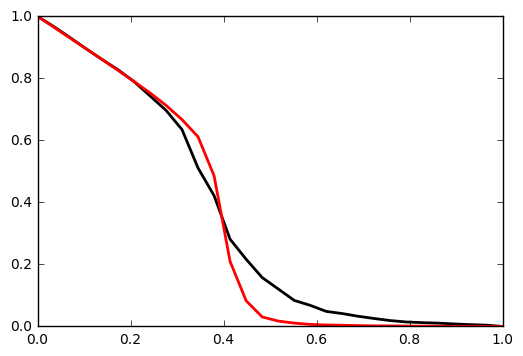

In [11]:
# Now lets plot the results
plt.plot(fractions, small_lat_orderpars, color='black', lw=2)
plt.plot(fractions, large_lat_orderpars, color='red', lw=2)

Here the larger graph, marked as the red line, has a far more distinct critical point. This is the effect of finite-size scaling. Most critical exponents and critical points are calculated as if the graph were of infinite size, but in practice graphs are much smaller and the result is a washing out of the critical point where it becomes less clear. There are more sophisticated approaches to correctly estimating the critical points and its critical exponents using a series of differently sized finite graphs, but unfortunately, most real world graphs don't have multiple instances to determine where the "actual" critical point is. So for our purposes it will be sufficient to let the critical point occur when the size of the giant component drops below 1% of its original value (which is what Barabasi does in the text book for table 8.1).


# Targeted attacks and network robustness
Here is what I want you to do for this assignment:

1. Write a function for targeted attacks that remove nodes in order of largest to smallest degree. It should take the same two arguments (networkx graph and removal fraction) as my `random_removal` function.

2. Choose any real-world network and create a bifurcation diagram similar to Figure 8.11 in the reading, which shows both the result of a targeted attack and a random attack on your network. Make sure to use a graph with many more than 100 nodes. Node removal is a discrete process, so 1% of anything less than a hundred is 0, meaning the whole network has to disappear and you won't see the critical point.

3. Determine the critical point for both attacks. This will be the point around which the giant component drops below 1% of its initial size.

4. Generate a random graph with the same size (N) and roughly the same number of edges (L) as your real-world graph and repeat steps 2-3 on that. (Note: you don't want to use the configuration model for this because percolation is strongly related to degree sequence, you can just use an erdos_renyi_graph)

5. Compare the robustness of your real-world graph to the random graph for both random and targeted node removal. How do the critical points compare? Are the results what you expected?

6. Submit your notebook to canvas when you are complete.



In [13]:
def targeted_attack(graph, remove_frac):
    
    # First, lets copy the graph so we don't change the original
    graph = graph.copy()
    
    # We need to calculate the current size of the largest component
    initial_largest = len(max(nx.connected_component_subgraphs(graph), key=len))
    RemovingNumber = int(remove_frac*len(graph))
    if RemovingNumber >= len(graph):
        return 0.0
    else:
        degreedict = graph.degree(graph.nodes())
        largest = sorted(degreedict, key=degreedict.get,reverse=True)[:RemovingNumber]
        graph.remove_nodes_from(largest)
    if len(graph) > 0:
        relative_size_of_largest = len(max(nx.connected_component_subgraphs(graph), key=len)) / initial_largest
    else:
        relative_size_of_largest = 0.0
        
    return relative_size_of_largest

The graph I am looking at is the weighted network of coauthorships between scientists posting preprints on the High-Energy Theory E-Print Archive between Jan 1, 1995 and December 31, 1999. M. E. J. Newman, Proc. Natl. Acad. Sci. USA 98, 404-409 (2001).
Now load the graph:

In [19]:
G = nx.read_pajek('hep-th.net')
G = nx.Graph(G)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 8361
Number of edges: 15751
Average degree:   3.7677


In [20]:
# This will be our list of fractions to run the simulation over
fractions = np.linspace(0.0, 1.0, 30)

# Lets do 20 trials for each fraction and take the mean, then do that for each fraction
random_attack_orderpars = [ np.mean([random_removal(G, frac) for i in range(20)]) for frac in fractions ]
targeted_attack_orderpars = [ np.mean([targeted_attack(G, frac) for i in range(20)]) for frac in fractions ]

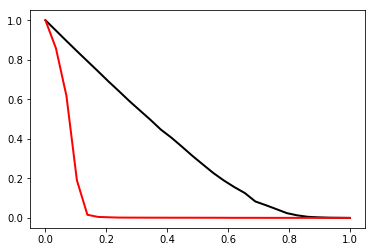

In [21]:
# Now lets plot the results
plt.plot(fractions, random_attack_orderpars, color='black', lw=2)
plt.plot(fractions, targeted_attack_orderpars, color='red', lw=2)

Determine the critical point for both attacks. This will be the point around which the giant component drops below 1% of its initial size.

In [26]:
def find_critical_point(orderpars,fractions):
    index = len(orderpars)-1
    for i in range(len(orderpars)):
        if orderpars[i]<0.01:
            index = i
            break
    critical_point = fractions[index]
    return critical_point

In [32]:
print('critical point for random attack: '+str(find_critical_point(random_attack_orderpars,fractions)))
print('critical point for targeted attack: '+ str(find_critical_point(targeted_attack_orderpars,fractions)))

critical point for random attack: 0.862068965517
critical point for targeted attack: 0.172413793103


Now we can test the random graph with similar number of nodes and edges

In [35]:
N = G.number_of_nodes()
L = G.size()
p = 2*L/(N*(N-1))
RG = nx.erdos_renyi_graph(N,p)
print(nx.info(RG))

Name: gnp_random_graph(8361,0.00045068554218177467)
Type: Graph
Number of nodes: 8361
Number of edges: 15650
Average degree:   3.7436


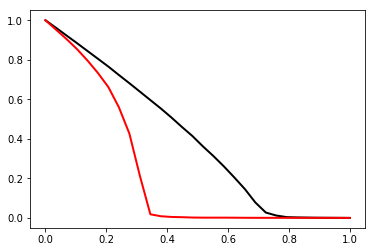

In [37]:
random_attack_orderpars = [ np.mean([random_removal(RG, frac) for i in range(20)]) for frac in fractions ]
targeted_attack_orderpars = [ np.mean([targeted_attack(RG, frac) for i in range(20)]) for frac in fractions ]
plt.plot(fractions, random_attack_orderpars, color='black', lw=2)
plt.plot(fractions, targeted_attack_orderpars, color='red', lw=2)

In [38]:
print('critical point for random attack: '+str(find_critical_point(random_attack_orderpars,fractions)))
print('critical point for targeted attack: '+ str(find_critical_point(targeted_attack_orderpars,fractions)))

critical point for random attack: 0.793103448276
critical point for targeted attack: 0.379310344828


### Results:
1. For the real network i used, it is scale-free, therefore, it is robust against random attacks, actually, the critical point for random attack is 0.86 which means that one needs to remove 86% of the nodes to break down the network. However, this network is vulnerable to targeted attacks aiming at hubs, the critical point is 0.17. This result is in line with our materials that while random node failures do not fragment a scale-free network, an attack that targets the hubs can easily destroy such network. 
2. For the random network, the critical point for random attack is 0.79, a little less than the real network. 0.79 is close to 1-1/avarage_degree. The critical point for targeted attack is 0.379, much larger than the one for real network because random network lacks hubs. Hence random network is more robust against targeted attacks. 